# 抽出された特徴量の評価

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import sklearn.preprocessing
%matplotlib inline


In [22]:
import glob

onomatpeia_list = [
    'clutter', 'gochagocha',
    'murmur', 'sarasara',
    'twinkle', 'kirakira',
]

dat = json.load(open("figure_features.json"))
dirname_list = []

for onomatpeia in onomatpeia_list:
    dirname_pattern = 'jsons/%s/*' % onomatpeia
    for dirname in sorted(glob.glob(dirname_pattern)):
        dirname_list.append(dirname)

shape_pool = np.load('shape_pool.npy')
shape_feat_pool = np.load('shape_feat_pool.npy')

In [23]:
for d, dirname in zip(dat, dirname_list):
    d = np.array(d)
    print dirname, "\t", d.mean(0)

jsons/clutter/JPN 	[ 0.          0.          0.          0.00574713  0.00574713  0.01149425
  0.01149425  0.02873563  0.41954023  0.5         0.01724138  0.          0.
  0.          0.          0.          0.          0.        ]
jsons/clutter/WRD 	[ 0.          0.          0.          0.          0.00689655  0.02068966
  0.00689655  0.05517241  0.37241379  0.48965517  0.02758621  0.0137931
  0.00689655  0.          0.          0.          0.          0.        ]
jsons/gochagocha/JPN 	[ 0.          0.00367647  0.00367647  0.00735294  0.01838235  0.03308824
  0.06617647  0.09926471  0.31617647  0.24264706  0.09191176  0.05514706
  0.02941176  0.01102941  0.01838235  0.00367647  0.          0.        ]
jsons/gochagocha/WRD 	[ 0.          0.          0.          0.          0.00534759  0.          0.
  0.11229947  0.47058824  0.31016043  0.07486631  0.02673797  0.          0.
  0.          0.          0.          0.        ]
jsons/murmur/JPN 	[ 0.          0.          0.          0.     

In [24]:
feat = np.array([np.array(d).mean(0) for d in dat])

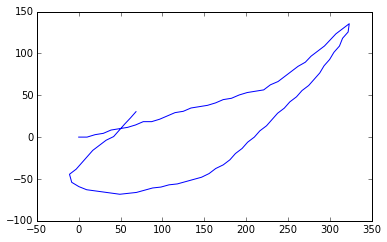

In [25]:
def gen_angle(idx):
    bin_range = 2 * np.pi / 18
    return np.random.random() * bin_range + bin_range * idx - np.pi


def randomwalk(feat, length):
    angle = []
    for i in range(length):
        idx = np.argmax(np.random.multinomial(1, feat))
        angle.append( gen_angle(idx) )
    angle = np.array(angle)
    
    path = gen_path(angle)
    
    return path

def gen_path(angle):
    point = np.zeros(2)
    path = [point.copy()]
    edge_len = 10
    direction = 0
    
    for a in angle:
        dp = np.array([np.cos(direction), np.sin(direction)]) * edge_len
        point += dp
        path.append(point.copy())
        direction += a

    path = np.vstack(path)

    return path


def poolwalk(feat, shape_pool, feat_pool, length):
    feat = np.array(feat)
    feat_pool = np.array(feat_pool)
    shape_pool = np.array(shape_pool)
    dist = np.linalg.norm(feat_pool - feat, axis=1)
    idx = np.argsort(dist)
    num = length / len(shape_pool[0])
    angle = np.hstack(shape_pool[idx][:num])
    return gen_path(angle)
    

def plot_path(path, marker=None):
    plt.subplot(111).set_aspect(1)

    plt.plot(*path.T, marker=marker)    

plot_path(poolwalk(feat[0], shape_pool[0], shape_feat_pool[0], 100))

In [26]:
def rotate(vec2, theta):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]])
    return vec2.dot(mat)
    

In [27]:
def gen_circle(n, radius):
    xs = []
    for i in range(n):
        a = i * np.pi * 2 / n
        xs.append([np.cos(a), np.sin(a)])
    return np.array(xs) * radius

In [48]:
norm = lambda x: sklearn.preprocessing.normalize(x, norm='l1')[0]

def gen_bone(path, sigma):
    window_ = scipy.signal.gaussian(len(path) * 2, sigma)
    def window(x):
        l = len(window_)/2
        return norm(window_[l-x:2*l-x])[:, None]
    bone = np.array([(path * window(i)).sum(0) for i in range(len(path))])
    return bone


def to_circle(path, sigma):
    bone = gen_bone(path, sigma)
    bone_edge = bone[1:] - bone[:-1]
    
    meat = []

    for i in range(len(path)-1):
        p = path[i] - bone[i]
        e = bone_edge[i]
        arg = np.arctan2(p[1], p[0]) - np.arctan2(e[1], e[0])
        scale = np.linalg.norm(p) / np.linalg.norm(e)
        meat.append([arg, scale])
    
    circle = gen_circle(len(path), 200)
    circle_edge = circle[1:] - circle[:-1]
    
    circle_path = []
    for i in range(len(path)-1):
        arg, scale = meat[i]
        e = circle_edge[i]
        c = circle[i]
        p = c + rotate(e, arg) * scale
        circle_path.append(p)

    circle_path = np.array(circle_path)
    return circle_path


def gen_avarage_shape(feat, shape_pool, feat_pool, length, sigma=5):
    path = poolwalk(feat, shape_pool, feat_pool, length)
    return to_circle(path, sigma)
#     return path


# 平均図形の生成

In [49]:
sigma = 10

jsons/kirakira/WRD


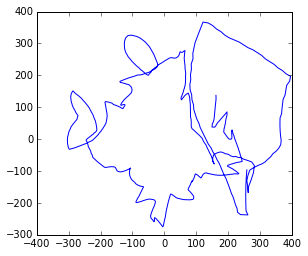

In [50]:
num = 11
dirname = dirname_list[num]
print dirname
feat = np.mean(dat[num], axis=0)

plot_path(gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], 1000, sigma=50))

In [54]:
for num in range(len(dirname_list)):
    dirname = dirname_list[num]
    feat = np.mean(dat[num], axis=0)
    plot_path(gen_avarage_shape(feat, shape_pool[num], shape_feat_pool[num], 1000, sigma=50))
    plt.savefig('avarage_images/%s.pdf' % dirname.replace('/', '_'), format='pdf')
    plt.clf()

In [65]:
for num in range(0, len(dirname_list), 4):
    feat = np.mean(np.vstack(dat[num:num+4]), axis=0)
    plot_path(gen_avarage_shape(feat, np.vstack(shape_pool[num:num+4]), np.vstack(shape_feat_pool[num:num+4]), 1000, sigma=50))
    dirname = '__'.join(dirname_list[num:num+4])
    plt.savefig('avarage_images/%s.pdf' % dirname.replace('/', '_'), format='pdf')
    plt.clf()